In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchinfo import summary
import pathlib
import glob
import pickle
import matplotlib.pyplot as plt
import time
import math
from collections import defaultdict
torch.set_float32_matmul_precision('high')

%matplotlib inline

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return {'data': dict[b'data'], 'labels': dict[b'labels']}

def combine_dicts(dicts: list)->dict:
    # keys: data, labels
    n = len(dicts)
    data, labels = dicts[0]['data'], dicts[0]['labels']
    for i in range(1,n):
        data = np.concatenate([data, dicts[i]['data']], axis=0)
        labels = labels + dicts[i]['labels']
    return {'data':data, 'labels':labels}

def array_to_rgb(arr: np.ndarray)->np.ndarray:
    # take an 1x3072
    # reshape to rgb: 32, 32, 3
    rgb = np.reshape(arr, (32, 32, 3), order='F').astype(dtype=np.float32)
    rgb = rgb / 255.
    # rotate by 90 degrees
    return np.rot90(rgb, k=1, axes=(1,0))

def show_image(arr: np.ndarray)->None:
    rgb_img = array_to_rgb(arr)
    print(rgb_img.shape)
    plt.figure(figsize=(1,1))
    plt.imshow(rgb_img)

def torch_from_numpy(arr: list)->torch.tensor:
    # convert to torch tensors
    #ndarrays = list(map(array_to_rgb, arr))
    tensors = [torch.from_numpy(item.copy()) for item in arr]
    return torch.einsum('nhwc->nchw', torch.stack(tensors, dim=0))

def make_dataset(d: dict)->list:
    data = list(map(array_to_rgb, d['data']))
    tensors = [torch.from_numpy(item.copy()) for item in data]
    tensors = torch.einsum('nhwc->nchw', torch.stack(tensors, dim=0))
    return list(zip(tensors, d['labels']))



In [3]:
# Conv block used in Resnet model
def conv_block(in_channels, out_channels, pool=False, activation=True):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same'),
              nn.BatchNorm2d(out_channels)]
    if activation:
        layers.append(nn.ReLU(inplace=True))
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# Transposed 2d convolution
def deconv_block(in_channels, out_channels, kernel_size=2, stride=2, padding=0, activation=True):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
              nn.BatchNorm2d(out_channels)]
    if activation:
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

# VAE Encoder: Resnet9
class Encoder(nn.Module):
    def __init__(self, in_channels, nf, latent_dim, device=torch.device('cpu')):
        super(Encoder, self).__init__()
        self.device = device
        self.nf = nf
        self.conv1 = conv_block(in_channels, nf)
        self.conv2 = conv_block(nf, 2*nf, pool=True)
        self.res1 = nn.Sequential(conv_block(2*nf, 2*nf), conv_block(2*nf, 2*nf))

        self.conv3 = conv_block(2*nf, 4*nf, pool=True)
        self.conv4 = conv_block(4*nf, 8*nf, pool=True)
        self.res2 = nn.Sequential(conv_block(8*nf, 8*nf), conv_block(8*nf, 8*nf))

        self.conv5 = conv_block(8*nf, 16*nf, pool=True)

        # Linear layer
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(16*nf*2*2, 32*nf),
                                    nn.ReLU(inplace=True))
        # mean and logvar linear layers
        self.mu_linear = nn.Sequential(nn.Linear(32*nf, latent_dim))
        self.logvar_linear = nn.Sequential(nn.Linear(32*nf, latent_dim))

        self.N = torch.distributions.Normal(0,1)
        self.N.loc = self.N.loc.to(self.device)
        self.N.scale = self.N.scale.to(self.device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.conv5(x)
        x = self.linear(x)
        mu = self.mu_linear(x)
        log_var = self.logvar_linear(x)
        return mu, log_var
    
# VAE Decoder : Resnet9
class Decoder(nn.Module):
    def __init__(self, nf, latent_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(latent_dim, 32*nf),
                                     nn.ReLU(inplace=True))
        self.linear2 = nn.Sequential(nn.Linear(32*nf, 16*nf*2*2),
                                     nn.ReLU(inplace=True))
        self.dconv1 = deconv_block(16*nf, 8*nf, kernel_size=3, stride=1)
        self.res1 = nn.Sequential(conv_block(8*nf, 8*nf), conv_block(8*nf, 8*nf))
        self.dconv2 = deconv_block(8*nf, 4*nf, kernel_size=5, stride=1)
        self.dconv3 = deconv_block(4*nf, 2*nf, kernel_size=9, stride=1)
        self.res2 = nn.Sequential(conv_block(2*nf, 2*nf), conv_block(2*nf, 2*nf))
        self.dconv4 = deconv_block(2*nf, nf, kernel_size=17, stride=1)
        self.dconv5 = conv_block(nf, 3,activation=False)
        

    def forward(self, z):
        z = self.linear1(z)
        z = self.linear2(z)
        z = z.view(z.shape[0],-1,2,2)
        z = self.dconv1(z)
        z = z + self.res1(z)
        z = self.dconv2(z)
        z = self.dconv3(z)
        z = z + self.res2(z)
        z = self.dconv4(z)
        xhat = self.dconv5(z)
        return xhat

# VAE model : Resnet based
class VAE(nn.Module):
    def __init__(self, in_channels, nf, latent_dim, n_classes=10, device=torch.device('cpu')):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(in_channels, nf, latent_dim, device)
        self.decoder = Decoder(nf, latent_dim)
        self.classifier = nn.Sequential(nn.Linear(latent_dim, n_classes))
        self.to(device)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        sigma = torch.exp(log_var/2)
        epsilon = self.encoder.N.sample(mu.shape)
        z = mu + sigma*epsilon
        out_targets = self.classifier(z)
        xhat = self.decoder(z)
        return xhat, x, mu, log_var, out_targets


In [4]:
"""
Annealing support for KL divergence

"""
class Annealer():
    def __init__(self, total_steps, shape, baseline=0.0, cyclical=True, disable=False):
        self.total_steps = total_steps
        self.baseline = baseline
        self.current_step = 0.0
        self.shape = shape
        self.cyclical = cyclical
        if disable:
            self.shape = None
            self.baseline = 0.0
    
    def __call__(self, kl_loss):
        return kl_loss * self.beta()

    def beta(self):
        if self.shape == 'linear':
            y = (self.current_step / self.total_steps)
        elif self.shape == 'cosine':
            y = (math.cos(math.pi * (self.current_step / self.total_steps - 1)) + 1) / 2
        elif self.shape == 'logistic':
            x = (self.total_steps/2)-self.current_step
            y = 1/(1+math.exp(x))
        elif self.shape == None:
            y = 1.0
        else:
            raise ValueError('Invalid shape for annealing function. Must be linear, cosine, or logistic.')
        out = y*(1-self.baseline) + self.baseline
        return out

    def step(self):
        if self.current_step < self.total_steps:
            self.current_step += 1
        if self.cyclical and self.current_step >= self.total_steps:
            self.current_step = 0

    def set_cyclical(self, value):
        if value is not bool:
            raise ValueError('Cyclical_setter method requires boolean argument (True/False)')
        else:
            self.cyclical = value
        return


In [5]:
def generate_samples(rows, cols, model):
    pathlib.Path("results/generated").mkdir(parents=True, exist_ok=True)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    save_fig_path = "results/generated/samples_"+timestr
    latent_dim = model.latent_dim
    z = model.encoder.N.sample([rows*cols,latent_dim])
    xhat = model.decoder(z)
    xhat = torch.einsum('nchw->nhwc',xhat)
    xhat = xhat.view(rows, cols, *xhat.shape[1:]).detach().cpu()
    print(xhat.shape)
    fig, axs = plt.subplots(rows, cols, figsize=(cols,rows))
    for A, I in zip(axs,xhat):
        for ax, img in zip(A,I):
            ax.set_aspect('equal')
            ax.axis('off')
            ax.imshow(img)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    plt.savefig(save_fig_path, facecolor='w', edgecolor='none')
    #plt.show()

def elbo_loss(xhat, x, mu, logvar, annealing_agent):
    batch_size = xhat.shape[0]
    recon_loss = F.mse_loss(xhat, x, reduction='sum') / batch_size
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),axis=1)
    kl_loss = kl_div.mean()
    kll = annealing_agent(kl_loss) #kl_loss/recon_loss
    total_loss = recon_loss + kll
    return total_loss, recon_loss, kl_loss, kll

def print_model_summary(model):
    #print(summary(model.encoder, input_size=(1,28,28)))
    #print(summary(model.decoder, input_size=(1, model.nf * 16)))
    print(summary(model))

def save_plots(losses, name=None):
    pathlib.Path("results").mkdir(parents=True, exist_ok=True)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    if not name:
        save_plot_path = "results/plot-"+timestr
    else:
        save_plot_path = "results/"+name
    epochs = len(losses['kl_loss'])
    plt.plot(range(1,epochs+1), losses['total_loss'], label='Total loss')
    plt.plot(range(1,epochs+1), losses['recon_loss'], label='Reconstruction loss')
    plt.plot(range(1,epochs+1), losses['kl_loss'], label='KL loss')
    #plt.plot(range(1,epochs+1), losses['cl_loss'], label='CL loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"VAE CIFAR10")
    plt.savefig(save_plot_path, facecolor='w', edgecolor='none')
    plt.show()

def save_model(model, name=None):
    pathlib.Path("results/saved_models").mkdir(parents=True, exist_ok=True)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    if not name:
        save_model_path = "results/saved_models/VAE_MNIST-"+timestr+".pth"
    else:
        save_model_path = "results/saved_models/"+name+".pth"
    torch.save(model.state_dict(), save_model_path)

# load model
def load_model(model_name, model_class, *args, **kwargs):
    model = model_class(*args, **kwargs)
    model_path = "results/saved_models/"+model_name+".pth"
    try:
        model.load_state_dict(torch.load(model_path, weights_only=True))
    except OSError as e:
        print(f"{e.strerror}: {e.filename}")
        return None
    return model

def train_model(model, device, train_loader, optimizer, loss_criterion, epoch, annealing_agent):
    model.train()
    train_loss = 0
    total_kl_loss = 0
    total_recon_loss = 0
    total_cl_loss = 0
    for batchidx, (data, targets) in enumerate(train_loader):
        #print(f"batch id: {batchidx}, data shape: {data.shape}")
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        xhat, x, mu, logvar, out_targets = model(data)
        classification_loss = loss_criterion(out_targets, targets)
        total_cl_loss += classification_loss.item()
        loss, recon_loss, kl_loss, kll = elbo_loss(xhat, x, mu, logvar, annealing_agent)
        #print(f"loss: {loss.item()}")
        total_loss = loss + classification_loss
        train_loss += total_loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_loss.backward()
        optimizer.step()
    annealing_agent.step()
    avg_kl_loss = total_kl_loss/(batchidx+1)
    avg_recon_loss = total_recon_loss/(batchidx+1)
    avg_loss = train_loss/(batchidx+1)
    avg_cl_loss = total_cl_loss/(batchidx+1)
    print(f"Train epoch: {epoch} [{(batchidx+1) * len(data)}/{len(train_loader.dataset)}\
          ({(100. * batchidx/len(train_loader)):.0f}%)]\tLoss: {avg_loss:.6f}\t")
    return avg_loss, avg_recon_loss, avg_kl_loss, avg_cl_loss

In [6]:
# check if output shape as expected
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 128
in_channels = 3
nf = 16
test_model = VAE(in_channels, nf, latent_dim, n_classes=10)
test_input = torch.randn(size=(64,3,32,32))
xhat,*_, out = test_model(test_input)
xhat.shape
#out.shape
#print_model_summary(test_model)

torch.Size([64, 3, 32, 32])

In [7]:
data_dir = "../data/"
train_files = glob.glob(data_dir + '**/*_batch_*', recursive=True)
test_files = glob.glob(data_dir + '**/*test_batch*', recursive=True)
train_files = list(map(unpickle, train_files))
test_files = list(map(unpickle, test_files))
test = combine_dicts(test_files)
train = combine_dicts(train_files)
print(test['data'].shape)
print(train['data'].shape)

(10000, 3072)
(50000, 3072)


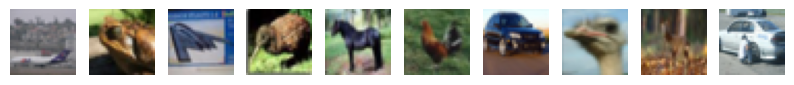

In [8]:
# plot sample images
sample_imgs = list(map(array_to_rgb, train['data'][0:10]))
_, axs = plt.subplots(1,10, figsize=(10,2))
axs = axs.flatten()
for img, ax in zip(sample_imgs, axs):
    ax.axis('off')
    ax.imshow(img)
plt.show()

(32, 32, 3)


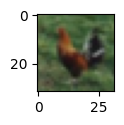

In [9]:
show_image(train['data'][5])

In [10]:
# convert to torch tensors
train_data = torch_from_numpy(list(map(array_to_rgb, train['data'])))
train_labels = np.array(train['labels'])
train_labels = torch.from_numpy(train_labels).reshape((train_labels.shape[0],-1))
print(f"train data shape: {train_data.shape}")
print(f"train labels shape: {train_labels.shape}")

train data shape: torch.Size([50000, 3, 32, 32])
train labels shape: torch.Size([50000, 1])


In [11]:
trainset = make_dataset(train)
#testset = make_dataset(test)
batch_size = 128
learning_rate = 0.2
latent_dim = 128
in_channels = 3
nf = 32
n_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(in_channels, nf, latent_dim, n_classes, device).to(device)
opt_model = torch.compile(model)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(opt_model.parameters(), lr=learning_rate)
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size, drop_last=True)
#test_loader = DataLoader(testset, shuffle=False, batch_size=batch_size, drop_last=True)
#print(f"test size: {len(testset)}")
print(f"train size: {len(trainset)}")
print(f"using device: {device}")
print_model_summary(opt_model)

train size: 50000
using device: cuda
Layer (type:depth-idx)                        Param #
OptimizedModule                               --
├─VAE: 1-1                                    --
│    └─Encoder: 2-1                           --
│    │    └─Sequential: 3-1                   960
│    │    └─Sequential: 3-2                   18,624
│    │    └─Sequential: 3-3                   74,112
│    │    └─Sequential: 3-4                   74,112
│    │    └─Sequential: 3-5                   295,680
│    │    └─Sequential: 3-6                   1,181,184
│    │    └─Sequential: 3-7                   1,181,184
│    │    └─Sequential: 3-8                   2,098,176
│    │    └─Sequential: 3-9                   131,200
│    │    └─Sequential: 3-10                  131,200
│    └─Decoder: 2-2                           --
│    │    └─Sequential: 3-11                  132,096
│    │    └─Sequential: 3-12                  2,099,200
│    │    └─Sequential: 3-13                  1,180,416
│    │  

Train epoch: 1 [49920/50000          (100%)]	Loss: 1979.750845	
Train epoch: 2 [49920/50000          (100%)]	Loss: 452.674176	
Train epoch: 3 [49920/50000          (100%)]	Loss: 118.312856	
Train epoch: 4 [49920/50000          (100%)]	Loss: 104.405231	
Train epoch: 5 [49920/50000          (100%)]	Loss: 103.142392	
Train epoch: 6 [49920/50000          (100%)]	Loss: 96.648417	
Train epoch: 7 [49920/50000          (100%)]	Loss: 90.295087	
Train epoch: 8 [49920/50000          (100%)]	Loss: 88.698082	
Train epoch: 9 [49920/50000          (100%)]	Loss: 86.921013	
Train epoch: 10 [49920/50000          (100%)]	Loss: 81.442760	
Train epoch: 11 [49920/50000          (100%)]	Loss: 78.813408	
Train epoch: 12 [49920/50000          (100%)]	Loss: 76.060790	
Train epoch: 13 [49920/50000          (100%)]	Loss: 75.294104	
Train epoch: 14 [49920/50000          (100%)]	Loss: 76.807632	
Train epoch: 15 [49920/50000          (100%)]	Loss: 79.138222	
Train epoch: 16 [49920/50000          (100%)]	Loss: 82.426

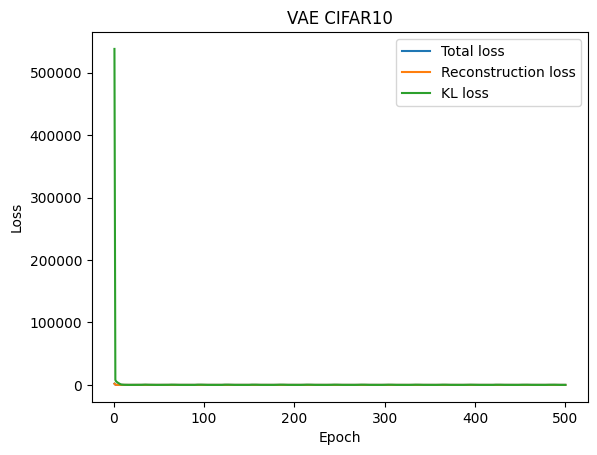

In [12]:
# Run training loops
baseline = 0.0
epochs = 500
annealing_shape = 'logistic'
annealing_steps = 30
annealing_agent = Annealer(annealing_steps, annealing_shape, baseline)
losses = defaultdict(list)
for epoch in range(1,epochs+1):
    avg_loss, avg_recon_loss, avg_kl_loss, avg_cl_loss = train_model(opt_model, device, train_loader, optimizer, loss_criterion, epoch, annealing_agent)
    losses['total_loss'].append(avg_loss)
    losses['recon_loss'].append(avg_recon_loss)
    losses['kl_loss'].append(avg_kl_loss)
    losses['cl_loss'].append(avg_cl_loss)
save_plots(losses)
save_model(model, name=f"vaecifar10_lr_{learning_rate}")

In [13]:
# load saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = f"vaecifar10_lr_{learning_rate}"
loaded_model = load_model(model_name,VAE,in_channels=in_channels, latent_dim=latent_dim, nf=nf, device=device)
if loaded_model:
    opt_model = torch.compile(loaded_model)
    print_model_summary(opt_model)

Layer (type:depth-idx)                        Param #
OptimizedModule                               --
├─VAE: 1-1                                    --
│    └─Encoder: 2-1                           --
│    │    └─Sequential: 3-1                   960
│    │    └─Sequential: 3-2                   18,624
│    │    └─Sequential: 3-3                   74,112
│    │    └─Sequential: 3-4                   74,112
│    │    └─Sequential: 3-5                   295,680
│    │    └─Sequential: 3-6                   1,181,184
│    │    └─Sequential: 3-7                   1,181,184
│    │    └─Sequential: 3-8                   2,098,176
│    │    └─Sequential: 3-9                   131,200
│    │    └─Sequential: 3-10                  131,200
│    └─Decoder: 2-2                           --
│    │    └─Sequential: 3-11                  132,096
│    │    └─Sequential: 3-12                  2,099,200
│    │    └─Sequential: 3-13                  1,180,416
│    │    └─Sequential: 3-14                 

torch.Size([5, 10, 32, 32, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09082599..0.8951891].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04615937..0.846842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2275447..1.019108].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012810726..0.6950876].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.31855115..1.0340166].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.049890596..0.95439416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0

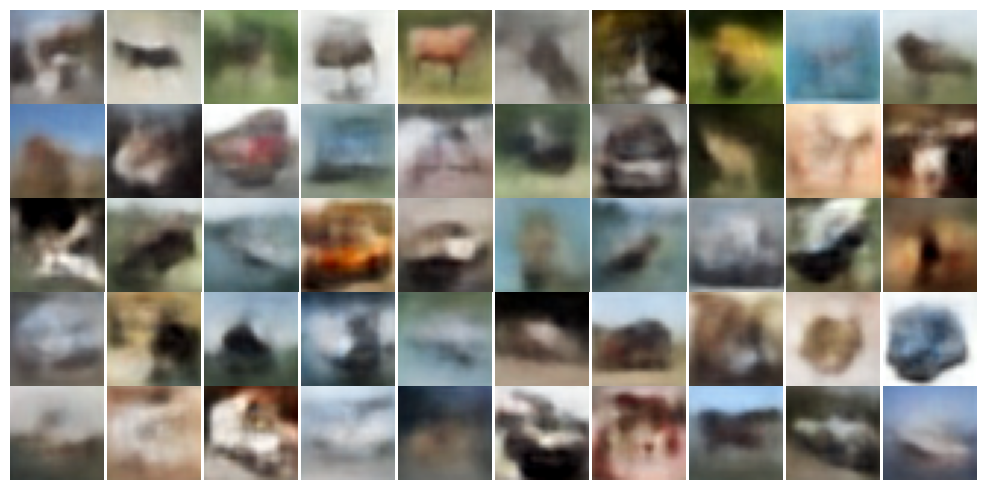

In [34]:
generate_samples(5,10,opt_model)